In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
# Load the data
train_data = pd.read_csv('Project 1 dataset/train.csv')
test_data = pd.read_csv('Project 1 dataset/test.csv')

#print(train_data.head())
#Variables Given: id, title, author, text, label

#print(test_data.head())
#Variables Given: id, title, author, text


In [3]:
# Combine the text columns into one for feature extraction
train_text = train_data['title'] + ' ' + train_data['author'] + ' ' + train_data['text']
test_text = test_data['title'] + ' ' + test_data['author'] + ' ' + test_data['text']

In [4]:
# Define stop words to remove from text
stop_words = set(stopwords.words('english'))

#Retrieves a set of stop words for the English language from the corpus.
#Assigns the set of stop words to the variable "stop_words" for use in text preprocessing to remove common words that may not be informative for the task at hand.

In [5]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

#Lemmatization is the process of reducing a word to its base form (called lemma) by applying linguistic rules 
#It can help in reducing the sparsity of the feature matrix and improve the performance of text classification models.

In [6]:
# Define a function for text preprocessing
def preprocess_text(text):
    if type(text) == float:
        # If the text is a missing value (NaN), replace it with an empty string
        text = ''
    # Tokenize the text
    words = word_tokenize(text.lower())

    # Remove stop words and words with less than 3 characters
    words = [word for word in words if word not in stop_words and len(word) > 2]

    # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Return the processed text as a string
    return ' '.join(words)

# Preprocess the text
train_text = train_text.apply(preprocess_text)
#print(train_text)
test_text = test_text.apply(preprocess_text)
#print(test_text)

In [7]:
# Extract features using TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
#ngram_range=(1, 2) specifies that the vectorizer should consider unigrams and bigrams as features.
#max_features=10000 limits the maximum number of features to 10,000.

train_features = vectorizer.fit_transform(train_text)
#transform the text data into a matrix of TF-IDF features

#print(train_features)
test_features = vectorizer.transform(test_text)
#print(test_features)

#The reason were are doing this is to extract features from the text data using the Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer
#This is a common technique in natural language processing for converting raw text into a numerical representation that can be used as input to machine learning algorithms.

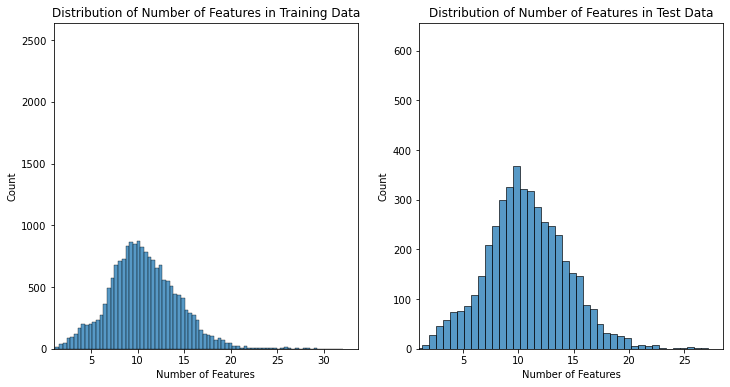

In [8]:
train_feature_counts = train_features.sum(axis=1).A1
#calculates the sum of features in each training sample and saves the result as an array.

test_feature_counts = test_features.sum(axis=1).A1
#calculates the sum of features in each test sample and saves the result as an array.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#creates a figure with two subplots. 

sns.histplot(train_feature_counts, ax=ax[0])
#creates a histogram of the distribution of feature counts in the training data and plots it on the first subplot.

ax[0].set_title('Distribution of Number of Features in Training Data')
ax[0].set_xlabel('Number of Features')
ax[0].set_xlim(left=1) # set the lower limit of x-axis to 1

sns.histplot(test_feature_counts, ax=ax[1])
ax[1].set_title('Distribution of Number of Features in Test Data')
ax[1].set_xlabel('Number of Features')
ax[1].set_xlim(left=1) # set the lower limit of x-axis to 1

plt.show()

#The output tells us that:
#Most of the documents have a small number of unique features, with very few documents having a large number of unique features.
#These features are crucial for distinguishing between different classes in the dataset.
#The most informative features are likely to be those that occur in a small number of documents, which is typical of text data.

In [9]:
# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=47)
#n_splits=5: This specifies the number of folds or partitions to create for the cross-validation process.
#shuffle=True: This argument shuffles the data before partitioning it into folds. This can help to avoid any bias that might be introduced by the original ordering of the data.
#random_state=42: This argument sets a random seed, which ensures that the same partitions will be created every time the code is run. This is important for reproducibility of the results.
#Note: I choose 47 because it's my favorite number, it doesn't matter what you put
accuracies = []
precisions = []
recalls = []
fscores = []

for train_index, val_index in kfold.split(train_features):
#The kfold.split(train_features) method returns indices that can be used to split the training data into "folds" or subsets. 
    #In this case, the n_splits parameter was set to 5, which means that the training data will be split into 5 different folds.
#The for loop iterates through these 5 folds, each time using a different fold as the validation set and the remaining folds as the training set. 
    #Specifically, on each iteration, train_index and val_index will be arrays containing the indices of the training and validation data, respectively.
    
    X_train, X_val = train_features[train_index], train_features[val_index]
    y_train, y_val = train_data['label'][train_index], train_data['label'][val_index]
    
    #X_train and y_train contain the features and labels from the training set, while X_val and y_val contain the features and labels from the validation set.
    #By doing this, the model can be trained on different subsets of the data during each iteration, allowing for a more accurate estimate of the model's performance.
    
    # Train a Naive Bayes classifier
    classifier = MultinomialNB()
    #Creates an instance of the Naive Bayes classifier with a multinomial distribution, which is suitable for text classification problems where the features represent word counts or frequencies.
    classifier.fit(X_train, y_train)
    #

    # Predict labels for the validation set
    y_pred = classifier.predict(X_val)
    #print(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)

In [10]:
# Calculate the average evaluation metrics over all folds
mean_accuracy = sum(accuracies) / len(accuracies)
mean_precision = sum(precisions) / len(precisions)
mean_recall = sum(recalls) / len(recalls)
mean_fscore = sum(fscores) / len(fscores)

print('Accuracy:', mean_accuracy)
print('Precision:', mean_precision)
print('Recall:', mean_recall)
print('F-score:', mean_fscore)

Accuracy: 0.8729807692307692
Precision: 0.9487620861523587
Recall: 0.7901763940133673
F-score: 0.8578984405396473
